### Загрузка данных

Гайд по скачиванию:
https://www.metagenomics.wiki/tools/fastq/ncbi-ftp-genome-download

In [35]:
import gzip

!wget 'https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000/355/675/GCF_000355675.1_ASM35567v1/GCF_000355675.1_ASM35567v1_genomic.fna.gz'
!wget 'https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000/355/675/GCF_000355675.1_ASM35567v1/GCF_000355675.1_ASM35567v1_genomic.gbff.gz'

!gunzip GCF_000355675.1_ASM35567v1_genomic.fna.gz
!gunzip GCF_000355675.1_ASM35567v1_genomic.gbff.gz

--2023-11-14 16:36:40--  https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000/355/675/GCF_000355675.1_ASM35567v1/GCF_000355675.1_ASM35567v1_genomic.fna.gz
Resolving ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)... 130.14.250.7, 130.14.250.10, 2607:f220:41e:250::12, ...
Connecting to ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)|130.14.250.7|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1168222 (1.1M) [application/x-gzip]
Saving to: ‘GCF_000355675.1_ASM35567v1_genomic.fna.gz’

GCF_000355675.1_ASM 100%[===================>]   1.11M  --.-KB/s    in 0.1s    

2023-11-14 16:36:40 (9.61 MB/s) - ‘GCF_000355675.1_ASM35567v1_genomic.fna.gz’ saved [1168222/1168222]

--2023-11-14 16:36:41--  https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000/355/675/GCF_000355675.1_ASM35567v1/GCF_000355675.1_ASM35567v1_genomic.gbff.gz
Resolving ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)... 130.14.250.12, 130.14.250.13, 2607:f220:41e:250::11, ...
Connecting to ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.

### Reading sequences

In [36]:
!pip install bio

Traceback (most recent call last):
  File "/usr/local/bin/pip3", line 5, in <module>
    from pip._internal.cli.main import main
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/main.py", line 10, in <module>
    from pip._internal.cli.autocompletion import autocomplete
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/autocompletion.py", line 10, in <module>
    from pip._internal.cli.main_parser import create_main_parser
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/main_parser.py", line 9, in <module>
    from pip._internal.build_env import get_runnable_pip
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/build_env.py", line 19, in <module>
    from pip._internal.cli.spinners import open_spinner
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/spinners.py", line 9, in <module>
    from pip._internal.utils.logging import get_indentation
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/util

In [37]:
from Bio import SeqIO
import numpy as np
import pandas as pd
from itertools import product
import matplotlib.pyplot as plt

seq = None
gb = None

# считываем скачанные файлы
for record in SeqIO.parse("/content/GCF_000355675.1_ASM35567v1_genomic.fna", "fasta"):
    seq = record.seq

for record in SeqIO.parse('/content/GCF_000355675.1_ASM35567v1_genomic.gbff', 'genbank'):
    gb = record

In [38]:
start, end = gb.features[0].location.start, None

ncod = []
cod = []

# записываем кодирующие и некодирующие последовательности
for i in range(len(gb.features)):
  feature = gb.features[i]
  fseq = feature.extract(seq)

  end = feature.location.start

  if feature.type == 'CDS' and fseq[:3] == 'ATG' and len(fseq) % 3 == 0:
    cod.append(fseq.__str__())

    if len(seq[start:end]) != 0:
      ncod.append(seq[start:end].__str__())

    start = feature.location.end

### Initial probabilities

In [39]:
def seq_probs(seq):
  return np.array([
      seq.count('T'), seq.count('C'),
      seq.count('A'), seq.count('G')
    ]) / len(seq)


def cod_probs(seq):
  res = []
  for i in range(3):
    res.append(seq_probs(seq[i::3]))
  return np.array(res)

def make_table1(cod_seqs, ncod_seqs):
  table1 = pd.DataFrame(np.vstack((cod_probs(''.join(cod_seqs)), seq_probs(''.join(ncod_seqs)))).T,
                       index=['T', 'C', 'A', 'G'],
                       columns=[f'pos{i}' for i in range(1, 4)] + ['nc'])
  return table1

In [40]:
t1 = make_table1(cod, ncod)
t1

,pos1,pos2,pos3,nc
T,0.181178,0.296080,0.315009,0.272761
C,0.206735,0.227039,0.233246,0.228978
A,0.256919,0.302102,0.238526,0.276553
G,0.355168,0.174779,0.213219,0.221708


### Transition probabilities

In [41]:
def cod_dprobs(seqs):
  dcounts = dict(
    zip([1, 2, 3],
        [dict(zip([''.join(pair) for pair in product('TCAG', repeat=2)],
                  [0] * 16)) for i in range(3)])
    )
  for seq in seqs:
    for i in range(1, len(seq)):
      dcounts[i % 3 + 1][seq[i-1:i+1]] += 1
  return get_probs(dcounts)

def ncod_dprobs(seqs):
    dcounts =dict(zip([''.join(pair) for pair in product('TCAG', repeat=2)],
                    [0] * 16))
    for seq in seqs:
      for i in range(1, len(seq)):
        dcounts[seq[i-1:i+1]] += 1

    return get_probs({0: dcounts})[0]

def get_probs(dcounts):
  for pos in dcounts:
    nuc_groups = dict(zip('TCAG', [0] * 4))
    for dup in dcounts[pos]:
      nuc_groups[dup[0]] += dcounts[pos][dup]
    for dup in dcounts[pos]:
      dcounts[pos][dup] /= nuc_groups[dup[0]]
  return dcounts

def make_table2(cod_seqs, ncod_seqs):
  table2 = pd.DataFrame(cod_dprobs(cod_seqs))
  table2[4] = pd.Series(ncod_dprobs(ncod_seqs))
  table2.rename(columns=dict(zip(np.arange(1, 5),
                                 [f'pos{i}' for i in range(1, 4)] + ['nc'])),
                inplace=True)
  table2.index = [prob_notation(idx) for idx in table2.index.values]
  return table2

def prob_notation(st):
  return st[1] + '|' + st[0]

In [42]:
t2 = make_table2(cod, ncod)
t2

,pos1,pos2,pos3,nc
T|T,0.185527,0.497941,0.316282,0.317919
C|T,0.189643,0.199367,0.179967,0.209093
A|T,0.249195,0.172458,0.221521,0.243747
G|T,0.375635,0.130234,0.282230,0.229240
T|C,0.185286,0.248599,0.269786,0.252206
C|C,0.156258,0.198068,0.244280,0.213760
A|C,0.276169,0.315114,0.244600,0.286907
G|C,0.382287,0.238219,0.241334,0.247126
T|A,0.179924,0.333963,0.307865,0.269894
C|A,0.194132,0.213885,0.193588,0.205527


TATTACTTC
P(seq NC)=P(T|NC)*Pnc(A|T)*Pnc(T|A)*P(T|T)*P(A|T)...

In [43]:
P_seq_nc = t1['nc']['T'] * t2['nc']['A|T']*t2['nc']['T|A']*t2['nc']['T|T']*t2['nc']['A|T']*t2['nc']['C|A']*t2['nc']['T|C']*t2['nc']['T|T']*t2['nc']['C|T']
P_seq_nc

4.7912814510831735e-06

In [44]:
t2['nc']['A|T']

0.24374699430844582

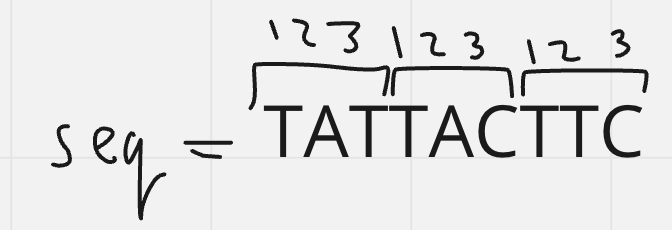

In [45]:
P_seq_cod = t1['pos1']['T']   * t2['pos2']['A|T'] * t2['pos3']['T|A'] * \
            t2['pos1']['T|T'] * t2['pos2']['A|T'] * t2['pos3']['C|A'] * \
            t2['pos1']['T|C'] * t2['pos2']['T|T'] * t2['pos3']['C|T']
P_seq_cod

9.893054273008876e-07

In [46]:
P_nc = 0.5
P_cod = 0.5
P_nc_seq = P_nc * P_seq_nc / (P_nc * P_seq_nc + P_cod * P_seq_cod)
P_nc_seq

0.8288572686278104

In [47]:
P_cod_seq = P_cod * P_seq_cod / (P_nc * P_seq_nc + P_cod * P_seq_cod)
P_cod_seq

0.17114273137218963

In [48]:
1-P_nc_seq

0.1711427313721896

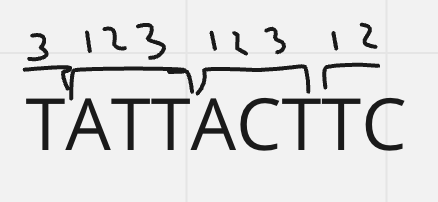

In [49]:
P_seq_cod2 = t1['pos3']['T'] * \
            t2['pos1']['A|T'] * t2['pos2']['T|A'] * t2['pos3']['T|T'] * \
            t2['pos1']['A|T'] * t2['pos2']['C|A'] * t2['pos3']['T|C'] * \
            t2['pos1']['T|T'] * t2['pos2']['C|T']
P_seq_cod2

4.409967752533561e-06

In [50]:
P_seq_cod3 = t1['pos3']['T'] * \
            t2['pos1']['A|T'] * t2['pos2']['T|A'] * t2['pos3']['T|T'] * \
            t2['pos1']['A|T'] * t2['pos2']['C|A'] * t2['pos3']['T|C'] * \
            t2['pos1']['T|T'] * t2['pos2']['C|T']
P_seq_cod3

4.409967752533561e-06

### Prediction

In [55]:
def cod_proba(seq, t1, t2, frame=1):
    if len(seq) == 0:
        print('No sequence')
        return None

    if frame not in [1, 2, 3]:
        print('No such frame')
        return None

    prev_nuc = seq[0]
    start_pos = None

    # LOG PROB INTIALIZATION
    # YOUR CODE
    start_pos = None
    if frame == 1:
        log_prob = np.log(t1[f'pos1'][seq[0]])
        start_pos = 1
        frame = 1
    elif frame == 2:
        log_prob = np.log(t1[f'pos3'][seq[0]])
        start_pos = 1
        frame = 0
    else:
        pair = f'{seq[1]}|{seq[0]}'
        log_prob = np.log(t1[f'pos1'][seq[0]]) + np.log(t2[f'pos2'][pair])
        start_pos = 2
        prev_nuc = seq[1]
        frame = 0

    for i, nuc in enumerate(seq[start_pos:], frame):
        pos = i % 3 + 1 # YOUR CODE
        pair = '{}|{}'.format(nuc, prev_nuc)
        log_prob += np.log(t2[f'pos{pos}'][pair]) # YOUR CODE
        prev_nuc = nuc
    return np.exp(log_prob)

def ncod_proba(seq, t1, t2):
    # YOUR CODE
    if len(seq) == 0:
        print('No sequence')
        return None

    prev_nuc = seq[0]
    log_prob = np.log(t1['nc'][seq[0]])
    for nuc in seq[1:]:
        pair = f'{nuc}|{prev_nuc}'
        log_prob += np.log(t2['nc'][pair])
        prev_nuc = nuc
    return np.exp(log_prob)

def get_cod_probs(seq, t1, t2):
    def _get_cod_probs_bonus(seq, t1, t2):
        prob1 = cod_proba(seq, t1, t2, frame=1)
        prob2 = cod_proba(seq, t1, t2, frame=2)
        prob3 = cod_proba(seq, t1, t2, frame=3)

        probnc = ncod_proba(seq, t1, t2)
        s = prob1 + prob2 + prob3 + probnc
        return {
            'c1': prob1 / s,
            'c2': prob2 / s,
            'c3': prob3 / s,
            'nc': probnc / s,
        }

    comp_seq = seq.reverse_complement()
    res = _get_cod_probs_bonus(comp_seq, t1, t2)

    return {
        **_get_cod_probs_bonus(seq, t1, t2),
        'neg_c1': res['c1'],
        'neg_c2': res['c2'],
        'neg_c3': res['c3'],
        'neg_nc': res['nc']
     }

In [56]:
from Bio.Seq import Seq

get_cod_probs(Seq("TATTACTTC"), t1, t2)

{'c1': 0.08254114911439882,
 'c2': 0.3679387536007669,
 'c3': 0.14976703236747346,
 'nc': 0.3997530649173609,
 'neg_c1': 0.4490981018431833,
 'neg_c2': 0.030682610875550766,
 'neg_c3': 0.35300564897104103,
 'neg_nc': 0.16721363831022495}

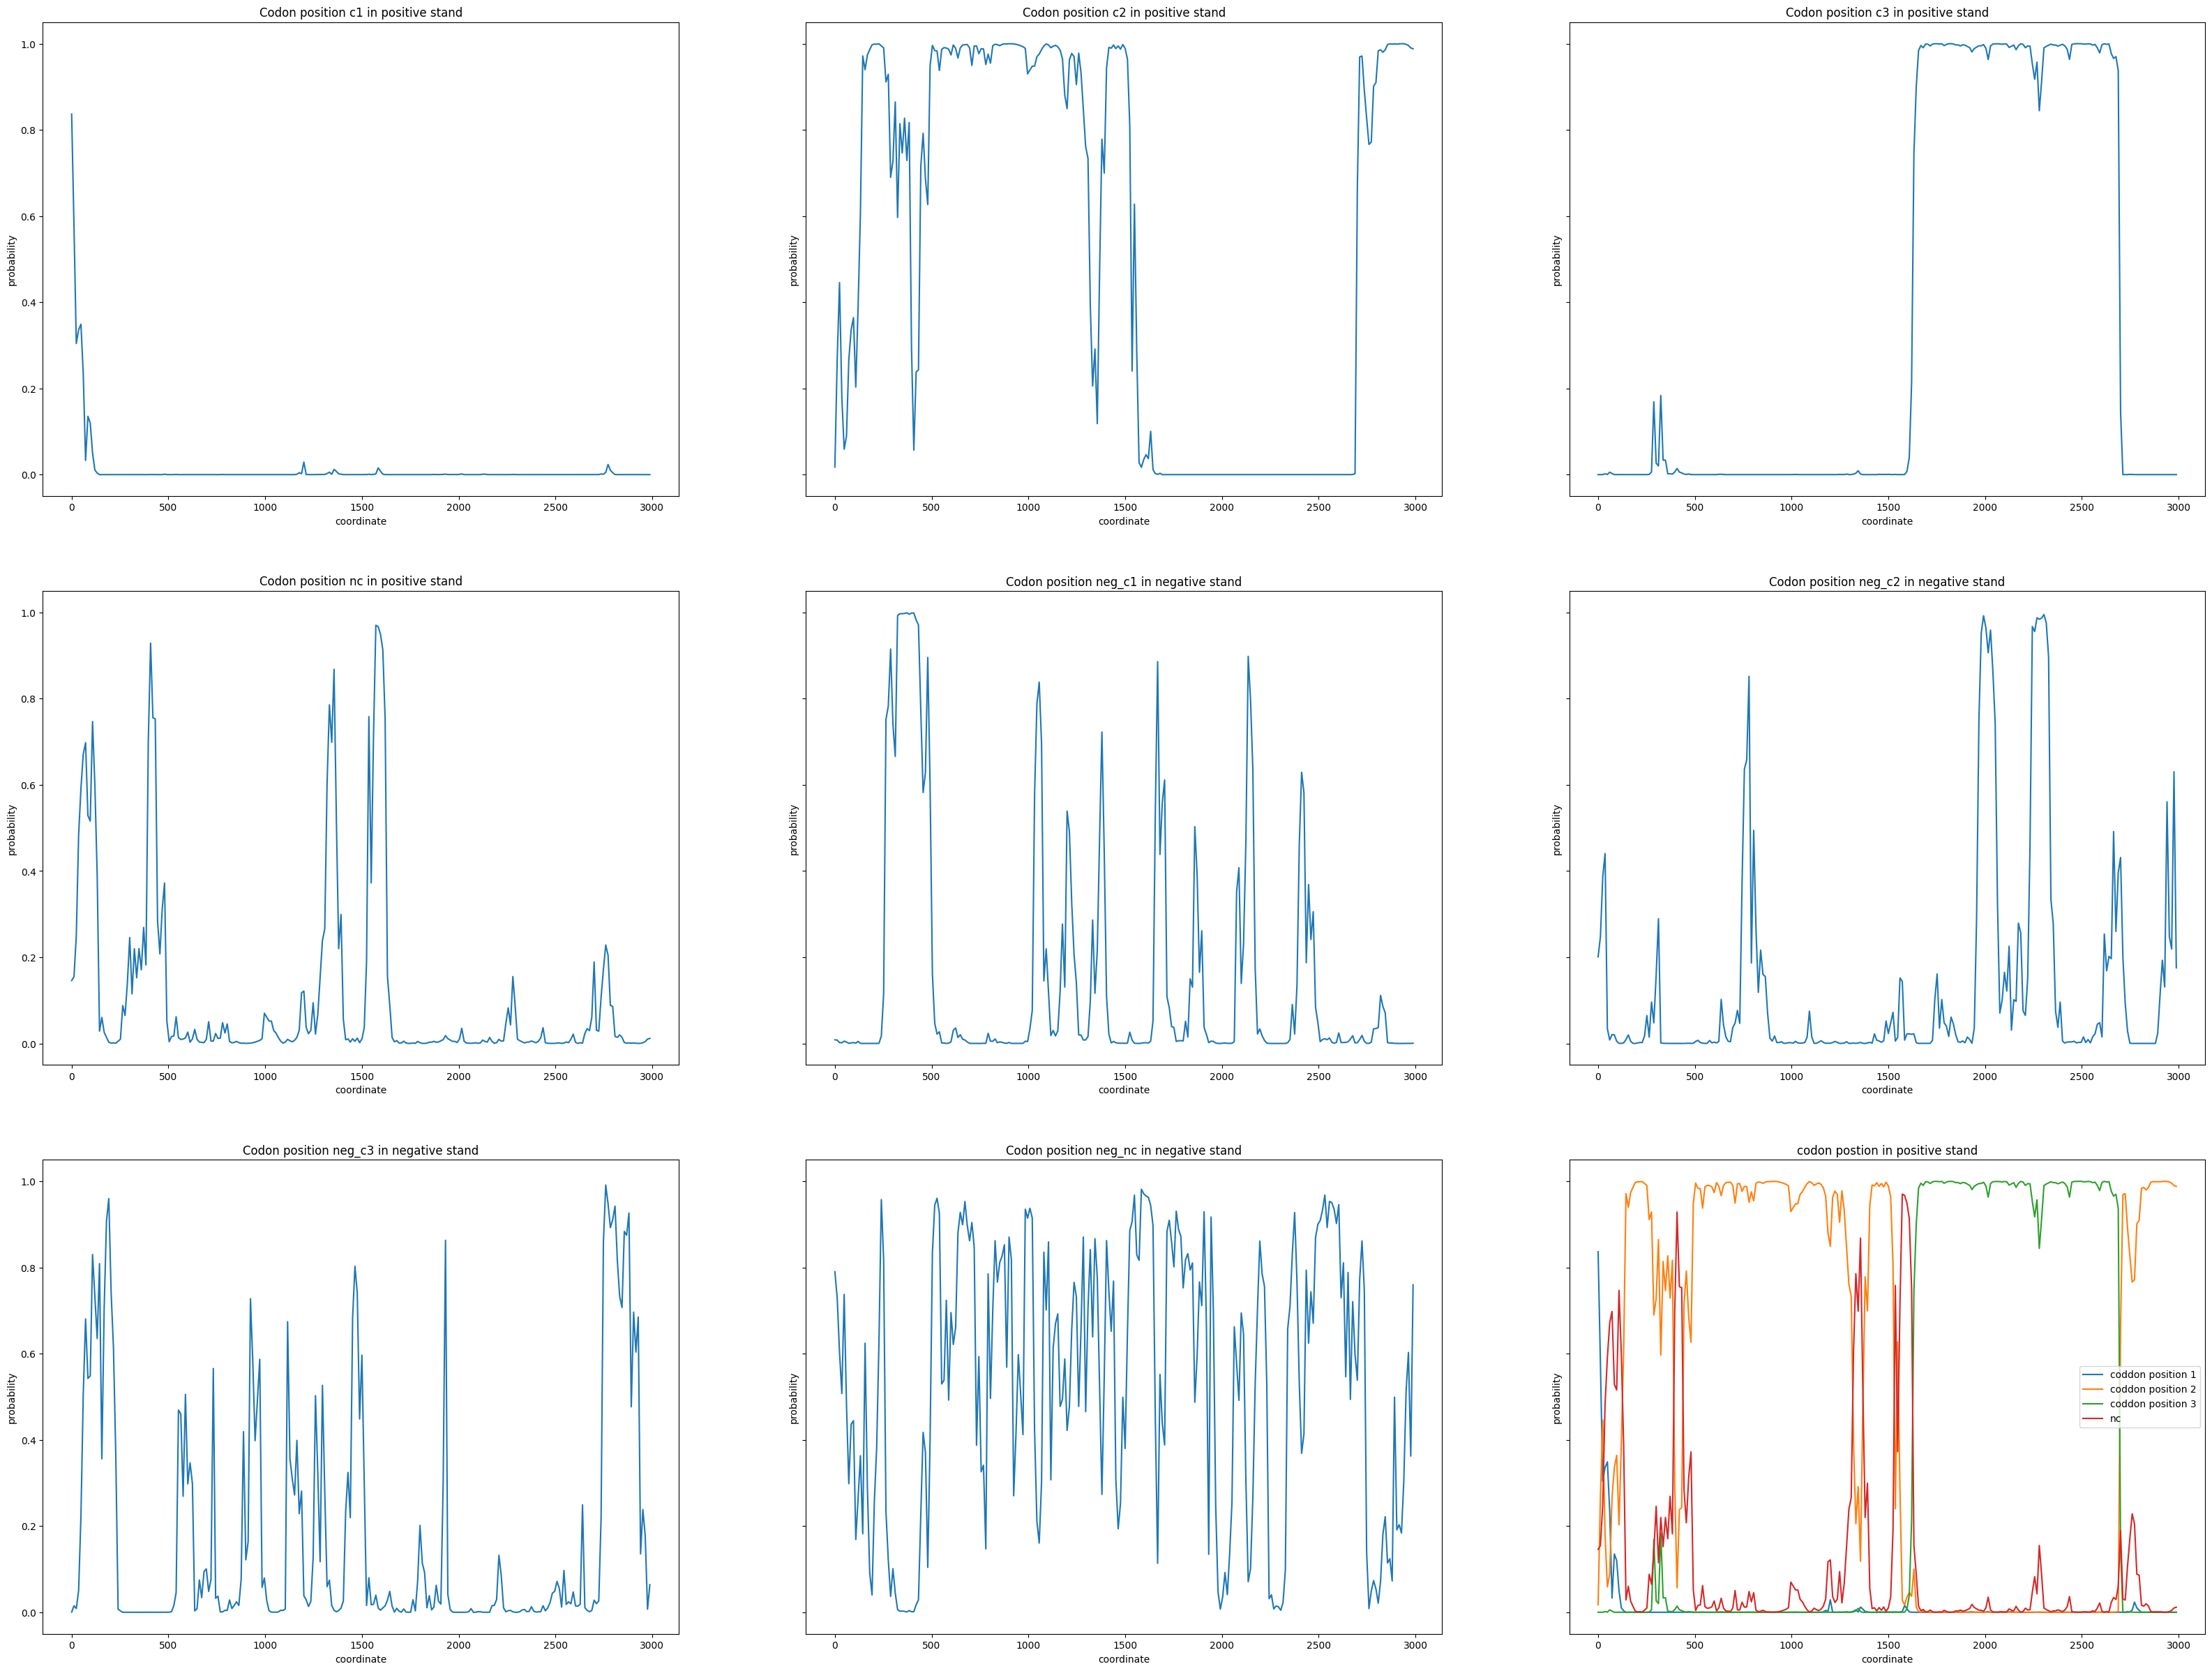

In [71]:
from collections import defaultdict

from matplotlib.pyplot import figure

FIGSIZE = (40, 30)

def setup_labels(ax):
    ax.set_xlabel("coordinate")
    ax.set_ylabel("probability")

def plot_graph(data, start, end, step):

    x = range(start, end, step)

    fig, axs = plt.subplots(3, 3, figsize=FIGSIZE, sharey='all')

    # YOUR CODE
    plots_data = [[axs[0, 0], 'c1'],
                  [axs[0, 1], 'c2'],
                  [axs[0, 2], 'c3'],
                  [axs[1, 0], 'nc'],
                  [axs[1, 1], 'neg_c1'],
                  [axs[1, 2], 'neg_c2'],
                  [axs[2, 0], 'neg_c3'],
                  [axs[2, 1], 'neg_nc']]

    for ax, name in plots_data:
        ax.plot(x, data[name])
        setup_labels(ax)
        ax.set_title(f"Codon position {name} in {'positive stand' if 'neg' not in name else 'negative stand'}")

    plots_data = [['c1', 'coddon position 1'],
                  ['c2', 'coddon position 2'],
                  ['c3', 'coddon position 3'],
                  ['nc', 'nc']]

    for key, label in plots_data:
        axs[2, 2].plot(x, data[key], label=label)

    setup_labels(axs[2, 2])
    plt.title(f"codon postion in positive stand")
    plt.legend()
    plt.plot()


start = 0
end = 3000
step = 12
window = 96
pos_probs = defaultdict(list)
for i in range(start, end, step):
    res = get_cod_probs(seq[i : i+window], t1, t2)
    for name in res:
        pos_probs[name].append(res[name])

plot_graph(pos_probs, start, end, step)

##Бонусная часть

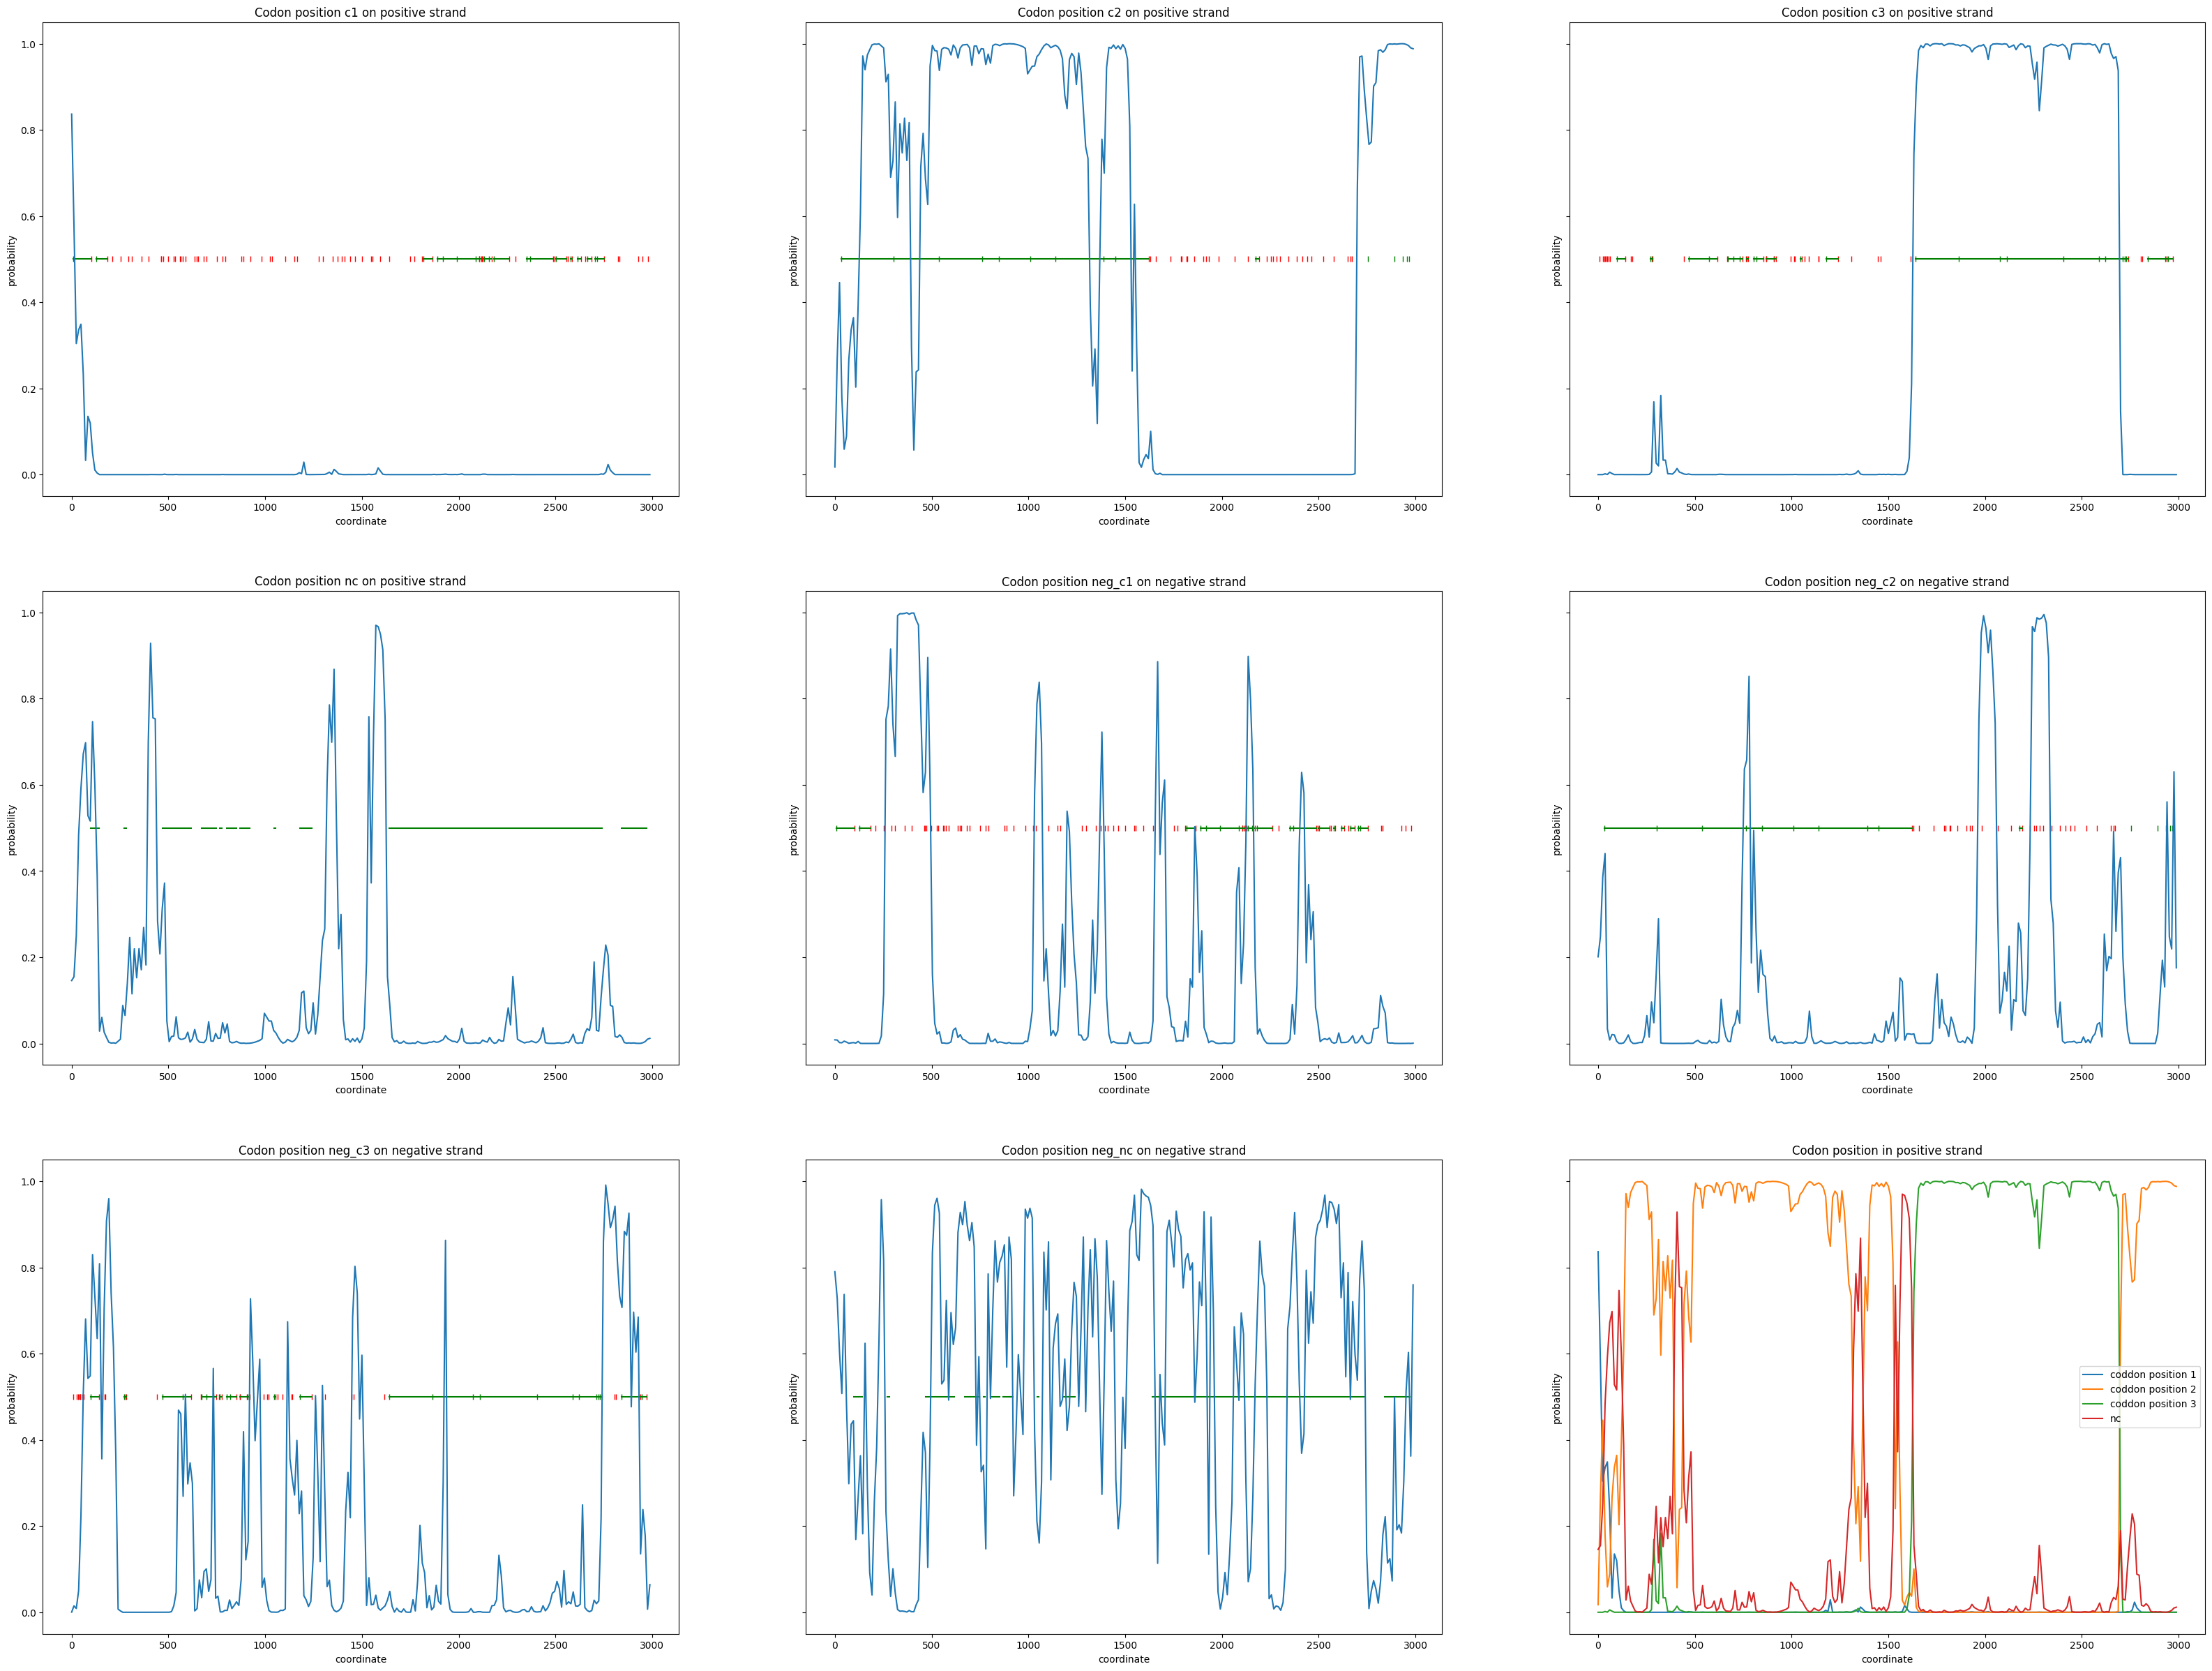

In [74]:
import seaborn as sns

def plot_graph_bonus(data, start, end, step, start_coords, stop_coords):
    x = range(start, end, step)

    fig, axs = plt.subplots(3, 3, figsize=FIGSIZE, sharey='all')

    # YOUR CODE
    plots_data = [[axs[0, 0], 'c1'],
                  [axs[0, 1], 'c2'],
                  [axs[0, 2], 'c3'],
                  [axs[1, 0], 'nc'],
                  [axs[1, 1], 'neg_c1'],
                  [axs[1, 2], 'neg_c2'],
                  [axs[2, 0], 'neg_c3'],
                  [axs[2, 1], 'neg_nc']]

    for ax, name in plots_data:
        if name in start_coords:
            starts = start_coords[name]
            ends = stop_coords[name]
            ax.plot(starts, [0.5] * len(starts), 'g|', label='Start codons')
            ax.plot(ends, [0.5] * len(ends), 'r|', label='Stop codons')

        i = 0
        j = 0
        while i < len(starts):
            while j < len(ends) and starts[i] >= ends[j]:
                j += 1
            if j >= len(ends):
                break
            ax.plot([starts[i], ends[j]], [0.5] * 2, 'g')
            while i < len(starts) and starts[i] <= ends[j]:
                i += 1
            if i >= len(starts):
                break

        ax.plot(x, data[name])
        setup_labels(ax)
        ax.set_title(f'Codon position {name} on ' + ('positive strand' if 'neg' not in name else 'negative strand'))

    plots_data = [['c1', 'coddon position 1'],
                  ['c2', 'coddon position 2'],
                  ['c3', 'coddon position 3'],
                  ['nc', 'nc']]

    for key, label in plots_data:
        plt.plot(x, data[key], label=label)

    setup_labels(axs[2, 2])
    plt.title(f'Codon position in positive strand')
    plt.legend()
    plt.show()


start = 0
end = 3000
step = 12
window = 96
pos_probs = defaultdict(list)

dna_seq = seq[:end]

def calculate_coords(offset):
    start_coords = []
    stop_coords = []
    for i in range(offset, len(dna_seq)-2, 3):
        codon = str(dna_seq[i:i+3])
        if codon == "ATG":
            start_coords.append(i)
        elif codon in ["TAA", "TAG", "TGA"]:
            stop_coords.append(i+2)
    return start_coords, stop_coords

start_coords = {}
stop_coords = {}
for strand in ['', 'neg_']:
    for offset in range(3):
        start_coords[f'{strand}c{offset + 1}'], stop_coords[f'{strand}c{offset + 1}'] = (
            calculate_coords(offset)
        )

for i in range(start, end, step):
    res = get_cod_probs(seq[i:i + window], t1, t2)
    for name in res:
        pos_probs[name].append(res[name])

plot_graph_bonus(pos_probs, start, end, step, start_coords, stop_coords)